In [10]:
import re 
import string
import timestring
from sklearn.linear_model import LinearRegression, LogisticRegression
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import cross_val_score, KFold
import glob, os
import numpy as np
from sklearn import svm
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint
from sklearn.feature_extraction import text

In [11]:
class Tokenizer:
    def __init__(self, collapse_mentions=False, collapse_digits=True):
        self.collapse_mentions = collapse_mentions
        self.collapse_digits = collapse_digits
        
    def tokenize(self, text):
        punc_re = '[' + '\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\_\\{\\|\\}' + ']'
        text = text.lower()
        text = re.sub('#(\S+)', r'HASHTAG_\1', text)
        if self.collapse_mentions:
            text = re.sub('@\S+', 'MENTION', text)
        else:
            text = re.sub('@\S+', 'MENTION_\1', text)
        text = re.sub('http\S+', 'THIS_IS_A_URL', text)
        text = re.sub(r'(.)\1\1\1+', r'\1', text)
        if self.collapse_digits: # Numbers help!
            text = re.sub(r'[0-9]', '9', text) 
        toks = []
        for tok in text.split():
            tok = re.sub(r'^(' + punc_re + '+)', r'\1 ', tok)
            tok = re.sub(r'(' + punc_re + '+)$', r' \1', tok)
            for subtok in tok.split():
                if re.search('\w', subtok):
                    toks.append(subtok)
        return toks

In [12]:
DIR = '/data/2/protest'

In [13]:
#read file with stopwords
def read_stopwords(path):
    return [s.strip().lower() for s in open(path)]

In [14]:
#define vectorizer 
toker = Tokenizer(collapse_digits=False, collapse_mentions=True)

#Adding new stopwords to the model
stopwords = set(read_stopwords(DIR + '/stopwords.txt'))    
my_stop_words = text.ENGLISH_STOP_WORDS.union(stopwords)

vectorizer = TfidfVectorizer(binary=False, decode_error='ignore',ngram_range=(1,2),
                                 max_df=1.0, min_df=2, use_idf=True,
                                 tokenizer=toker.tokenize,
                                 norm='l2', stop_words=set(my_stop_words))

In [15]:
def read_keywords(path):
    return [s.strip().lower() for s in open(path)]
    
keywords = read_keywords(DIR + '/keywords.txt')
keywords

['foradilma', 'fora dilma', 'forapt', 'fora pt', 'vemprarua', 'vem pra rua']

In [27]:
import os, io, json, codecs

def matches_keywords(text, keywords):
    """ Return true if any keyword is a substring of this text, ignoring case. """
    text = text.lower()
    for kw in keywords:
        if kw in text:
            return True
    return False

def filename2user(fname):
    """Convert filename like this
      /data/2/protest/Timeline/MandinhaSimone.txt.txt
    into a username like
      MandinhaSimone
    """
    return re.sub(r'^([^\.]+)\..+', r'\1', os.path.basename(fname))

def after_iterate_instances_changed(files, keywords, window_sz, gap_sz):
    """
    Return an iterator over tuples containing:
    (concatenated tweet text, label, username, percentage of neightbors who used one of the keywords)
    For each user in path, we find the first tweet containing one of the specified keywords.
    We then create one positive instance, defined as window = N tweets prior to the matched tweet.
    We also create one negative instance, which is the same size as positive, but defined after a gap=g.
    We additionally filter users if they use one of the keywords in one of their first (2*window + gap)
    tweets. 
    Also we find neighbors (define as those with symetric mentions) who have also used one of the keywords 
    during positive or negative window 
    """
    DIR = '/home/elaine/Protest/protest/Brazil project/'
    DIR2='/data/2/protest/mentions/'
    dic = defaultdict(tuple)
    #pkl_file = open(DIR+'all_mentions_graph.pkl', 'rb')#open pickle file where the edges of the graph is saved
    #data1 = pickle.load(pkl_file)
    for _, _, f in os.walk(DIR2): f    
    for _, _, arquivos in os.walk(files): arquivos
        
    for fname in arquivos:
        #print(fname)
        user = filename2user(fname)
        #print('this is', user)
        lines = []
        lines_neg = []
        #countneg=0
        #countpos=0
        #print('treino',user)
        #print(open(files+arquivos[fname]))
        for i, line in enumerate(open(files+fname)):
            js = json.loads(line)
                # exclude people who use keyword within first `window` of tweets.
            if i <= (2*window_sz + gap_sz) and matches_keywords(js['text'], keywords):
                #print('skipping', arquivos[fname], 'because uses keyword in first', negative_window, 'tweets')
                break
            if i > (2*window_sz + gap_sz) and matches_keywords(js['text'], keywords):
                #yield (' '.join(lines), 1, user)
                # yield (' '.join(lines[:-negative_window]), 0, user)
                lines.append((js['text'],js['created_at']))
            if not(matches_keywords(js['text'],keywords)):
                lines_neg.append((js['text'],js['created_at']))
    
                
                
        testepos = " ".join(l[0] for l in lines)
        testeneg = " ".join(l[0] for l in lines_neg)
                
        yield (testepos, 1, user)
        yield (testeneg, 0, user)

            
y = []
users = []
negative_window = 10
# The loop below iterates over each instance and vectorizes the text.
# Simulataneously, we append to the y (labels) and users lists.
# We do this to avoid having to store all the text in memory at once and to 
# only require one loop through the files.(files, keywords, window_sz, gap_sz,files_train
iterator = after_iterate_instances_changed(DIR + '/Timeline/', keywords, 20,100)
X = vectorizer.fit_transform(x[0] for x in iterator if not users.append(x[2]) and not y.append(x[1]))
print('read %d instances into X matrix with shape %s' % (len(users), str(X.shape)))
print('label distribution=', Counter(y))

#iterator = iterate_instances(DIR + '/Timeline', keywords, negative_window)
#i=list(iterator)


read 642 instances into X matrix with shape (642, 339508)
label distribution= Counter({0: 321, 1: 321})


In [23]:
y = np.array(y)
model_mod = LogisticRegression(penalty='l2', C=2.6)
model_mod.fit(X, y)


# Compute accuracy
def accuracy(truth, predicted):
    return (1. * len([1 for tr, pr in zip(truth, predicted) if tr == pr]) / len(truth))

# 10 Cross-validation accuracy
cv = KFold(len(y), 10, shuffle=False)  # Don't shuffle b/c we don't want a user in both training and testing set.
accuracies = []
for train_ind, test_ind in cv:
    model_mod.fit(X[train_ind],y[train_ind])   
    accuracies.append(accuracy_score(y[test_ind], model_mod.predict(X[test_ind])))
    
print('Average 10-fold cross validation accuracy=%.4f (std=%.2f)' % (np.mean(accuracies), np.std(accuracies)))

predicted = model_mod.predict(X)
print('accuracy on training data=%.4f' % accuracy(y, predicted))

Average 10-fold cross validation accuracy=0.9393 (std=0.02)
accuracy on training data=0.9751


In [24]:
from pprint import pprint 
coefs = sorted(zip(vectorizer.get_feature_names(), model_mod.coef_[0]),key=lambda x:x[1])
pprint(coefs[:30])
pprint(coefs[-30:])

[('MENTION', -5.2257298810562158),
 ('THIS_IS_A_URL', -4.227552444607789),
 ('HASHTAG_somostodossergiomoro', -1.4893833173014652),
 ('eu', -1.4674372915096341),
 ('rt', -1.0869185009509323),
 ('rt MENTION', -1.0416741051499223),
 ("THIS_IS_A_URL i'm", -0.92877233422348993),
 ("i'm", -0.84592901329289882),
 ('bom', -0.81384897450187221),
 ('ser', -0.81183133436800792),
 ('THIS_IS_A_URL MENTION', -0.76368825775916083),
 ('deus', -0.74078886193204263),
 ('HASHTAG_trndnl', -0.71717604961607084),
 ('THIS_IS_A_URL HASHTAG_trndnl', -0.71717604961607084),
 ('THIS_IS_A_URL THIS_IS_A_URL', -0.70596333198766803),
 ('vai', -0.65764374990020846),
 ('muito', -0.65364718513111386),
 ('dia', -0.62753882525598581),
 ('HASHTAG_tdc', -0.60517540876090059),
 ('te', -0.60282448343122785),
 ('vida', -0.60091921443958629),
 ('são', -0.59692771180091531),
 ('HASHTAG_desesperodaveja', -0.59663402336894777),
 ('HASHTAG_sabadocomdetremuranosdv THIS_IS_A_URL', -0.58463552728785972),
 ('depoimento youssef', -0.569

In [25]:
def do_cv(X, y, nfolds=10):
    y = np.array(y)
    cv = KFold(len(y), nfolds, shuffle=False)
    return np.mean(cross_val_score(LogisticRegression(), X, y, cv=cv))

In [26]:
def create_feature_vector(iterator, vectorizer_):
    y=[]
    X = vectorizer_.fit_transform(x[0] for x in iterator if not users.append(x[2]) and not y.append(x[1]))
    print('X dimensions=', X.shape)
    return X,y

Populating the interactive namespace from numpy and matplotlib
(1, 1)
X dimensions= (570, 36214)
(1, 2)
X dimensions= (570, 152438)
(2, 2)
X dimensions= (570, 116224)
(1, 3)
X dimensions= (570, 214327)
(2, 3)
X dimensions= (570, 178113)
(3, 3)
X dimensions= (570, 61889)


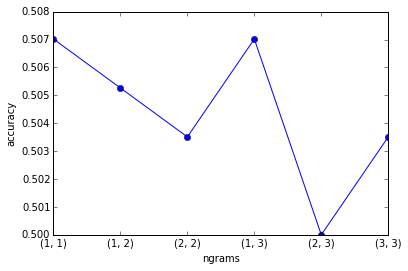

In [16]:
# How does using ngrams help?
import matplotlib.pyplot as plt
%pylab inline
def compare_ngrams(y):
    accuracies = []
    ngrams = [(1,1), (1,2), (2,2), (1,3), (2, 3), (3,3)]
    for ngram in ngrams:
        iterator = iterate_instances(DIR + '/Timeline', keywords, negative_window)
        print(ngram)
        a=create_feature_vector(iterator, TfidfVectorizer(decode_error='ignore',
                             use_idf=True, tokenizer=tokenize, ngram_range=ngram, min_df=5))
        accuracies.append(do_cv(a[0],a[1]))
    plt.figure()
    plt.plot(accuracies, 'bo-')
    plt.xticks(range(len(ngrams)), ngrams)
    plt.xlabel('ngrams')
    plt.ylabel('accuracy')
    plt.show()

#iterator = iterate_instances(DIR + '/Timeline', keywords, negative_window)
compare_ngrams(y)

X dimensions= (548, 1521921)
X dimensions= (548, 1521921)
X dimensions= (548, 1495657)
X dimensions= (548, 272452)
X dimensions= (548, 267505)
X dimensions= (548, 152244)
X dimensions= (548, 149494)
X dimensions= (548, 105986)
X dimensions= (548, 104084)
X dimensions= (548, 80877)
X dimensions= (548, 79367)
X dimensions= (548, 65322)
X dimensions= (548, 64179)
X dimensions= (548, 54801)
X dimensions= (548, 53817)
X dimensions= (548, 46994)
X dimensions= (548, 46183)
X dimensions= (548, 41162)
X dimensions= (548, 40407)
X dimensions= (548, 36416)


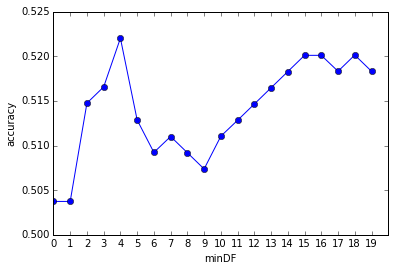

In [35]:
def compare_mindDF(y):
    accuracies = []
    for freq in range(20):
        iterator = iterate_instances(DIR + '/Timeline', keywords, negative_window)
        a=create_feature_vector(iterator, TfidfVectorizer(decode_error='ignore', min_df=freq, max_df=1.,ngram_range=(1,2),
                                                          use_idf=True, tokenizer=tokenize))
        accuracies.append(do_cv(a[0],a[1]))
    plt.figure()
    plt.plot(accuracies, 'bo-')
    plt.xticks(range(20))
    plt.xlabel('minDF')
    plt.ylabel('accuracy')
    plt.show()
compare_mindDF(y)

1.0
X dimensions= (570, 36214)
0.1
X dimensions= (570, 31440)
0.05
X dimensions= (570, 27253)
0.04
X dimensions= (570, 25319)
0.03
X dimensions= (570, 22286)
0.02
X dimensions= (570, 16507)
0.01
X dimensions= (570, 313)


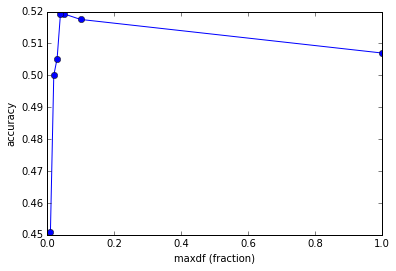

In [26]:
# How does filtering common words affect accuracy?
import matplotlib.pyplot as plt

def compare_maxdf(y):
    accuracies = []
    maxdfs = [1., .1, .05, .04, .03, .02, .01]
    for freq in maxdfs:
        print(freq)
        iterator = iterate_instances(DIR + '/Timeline', keywords, negative_window)
        a=create_feature_vector(iterator, TfidfVectorizer(decode_error='ignore', max_df=freq, min_df=5, ngram_range=(1,1),
                             use_idf=True, tokenizer=tokenize))
        accuracies.append(do_cv(a[0],a[1]))
    plt.figure()
    plt.plot(maxdfs, accuracies, 'bo-')
    plt.xlabel('maxdf (fraction)')
    plt.ylabel('accuracy')
    plt.show()
        
compare_maxdf(y)

True
X dimensions= (570, 184830)
False
X dimensions= (570, 184830)


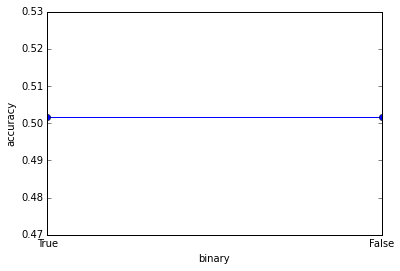

In [134]:
# Does binary/freq help?
def compare_binary(y):
    accuracies = []
    choices = [True, False]
    for choice in choices:
        print(choice)
        iterator = iterate_instances(DIR + '/Timeline', keywords, negative_window)
        a=create_feature_vector(iterator, TfidfVectorizer(decode_error='ignore',
                             use_idf=True, tokenizer=tokenize, binary=choice, norm='l2'))
        accuracies.append(do_cv(a[0],a[1]))
    plt.figure()
    plt.plot(accuracies, 'bo-')
    plt.xticks([0,1], [str(c) for c in choices])
    plt.xlabel('binary')
    plt.ylabel('accuracy')
    plt.show()
        
compare_binary(y)

True
X dimensions= (570, 184830)
False
X dimensions= (570, 184830)


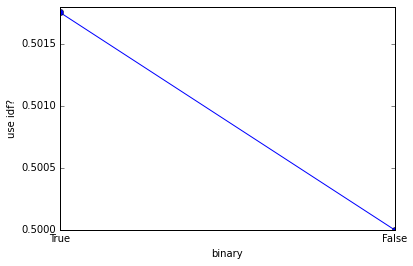

In [136]:
# Does idf help?
def compare_idf(y):
    accuracies = []
    choices = [True, False]
    for choice in choices:
        print(choice)
        iterator = iterate_instances(DIR + '/Timeline', keywords, negative_window)
        a=create_feature_vector(iterator, TfidfVectorizer(decode_error='ignore',
                             use_idf=choice, tokenizer=tokenize, norm='l2'))
        accuracies.append(do_cv(a[0],a[1]))
    plt.figure()
    plt.plot(accuracies, 'bo-')
    plt.xticks([0,1], [str(c) for c in choices])
    plt.xlabel('binary')
    plt.ylabel('use idf?')
    plt.show()
        
compare_idf(y)

In [30]:
# Do GridSearch on all parameters.

pipeline = Pipeline([
    ('vect', TfidfVectorizer(decode_error='ignore')),
    ('clf', LogisticRegression()),
])

parameters = {
    'vect__ngram_range': ((1, 1), (1, 2), (1, 3),(2,2),(2,3)),  # unigrams or bigrams or trigrams
    'vect__max_df':(1., .1, .05, .04, .03, .02),
}

iterator = after_iterate_instances_changed(DIR + '/Timeline/', keywords, 20,100)
data = [item[0] for item in iterator]
grid_search = GridSearchCV(pipeline, parameters, verbose=1, cv=KFold(len(y), 10,shuffle=False))

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
grid_search.fit(data, y)
print("done.")

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (1.0, 0.1, 0.05, 0.04, 0.03, 0.02),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3))}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed: 35.0min
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed: 139.3min
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 210.3min finished


done.
Best score: 0.949
Best parameters set:
	vect__max_df: 1.0
	vect__ngram_range: (1, 1)
